Code to detect shower events using the derivative: computes ratio of the number of positive values of the derivative
in a given time window over the total number of values in this time window.

In [1]:
from __future__ import division
import processFile
import numpy as np
from math import floor
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [20]:
# enter sensor type (pressure, accelerometer, humidity, magnetometer, temperature, luxometer)
value_type = "humidity"

# indicate if file type is new (with sensor id) or old (first version of the csv files): True or False
new = True

# enter directory
directory = 'New data/sensor files/'
# enter file name
file = directory + '20160402112805 to 20160405113116 B0B448B8A585 Humidity(rH).csv'

time, data = processFile.openFile(file, value_type, new, False)
print data.shape

Opening file...
(603247,)


In [21]:
time[4:10]

array([ 0.03336667,  0.03461667,  0.05031667,  0.05036667,  0.06661667,
        0.06758333])

In [22]:
# process data if necessary (eg remove some faulty values)
index = data > 13
data = data[~index]
time = np.array(time)
time = time[~index]

In [23]:
if value_type == "temperature":
    ambient_temp = data[:,0]
    object_temp = data[:,1]
    data = ambient_temp


def derivative(time, data):
    # Computes derivative of data
    Dtime = np.diff(time)
    Ddata = np.diff(data)
    Ddata /= Dtime
    return Ddata

def derivative_analysis(time, data, window_length):
    """
    :param time: timestamps vector
    :param data: sensor readings vector (temperature or humidity)
    :param window_length: in minutes
    :return: array output. output[:,4] contains the ratio of positive values of the derivative over the total number
    of values in a given window length, output[:,1] contains first time of window
    """
    print "window length: ", window_length , " minutes"

    Ddata = derivative(time, data)

    m = len(time)
    print 'len(time):', m
    print 'max(time):', max(time)
    # if time is in minutes, divide max time by window length to know length of loop
    limit = int(max(time)/(window_length))
    print "limit: ", limit

    output = np.zeros((limit,5))

    timer = time[0]
    time_temp = time[:m-1]
    Ddata_temp = Ddata
    #print "Data_temp", Ddata_temp

    for i in range(1, limit):

        end_window = timer + window_length
        #temp = time>=timer and time<end_window
        temp = time_temp >= timer
        time_temp = time_temp[temp]
        Ddata_temp = Ddata_temp[temp]
        temp = time_temp < end_window
        d = Ddata_temp[temp]

        # print Ddata_temp
        # print Ddata_temp>0
        output[i, 0] = timer
        output[i, 1] = np.sum(d>0)
        output[i, 2] = np.sum(d==0)
        output[i, 3] = np.sum(d<0)
        m_temp = d.shape[0]
        if m_temp != 0:
            output[i, 4] = output[i, 1]/m_temp
        else:
            output[i, 4] = 0.0
        #if i % 10000 == 0: print i, m_temp, output[i,:]
        timer += window_length

    return output


def plot_output(output):
    plt.plot(output[:,0], output[:,4], color='c', label='output')
    plt.title("Ratio of positive values in the derivative, 2 minute time window")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Ratio of positive values over total values in the derivative")
    plt.show()


def shower_detection(time, data, window_length, threshold):
    """
    :param threshold: to adjust to have better results
    :return: y, boolean vector indicating if an event has been detected at a particular time window
    """
    output = derivative_analysis(time, data, window_length)
    y = output[:,4]
    y = y>threshold

In [24]:
window_length = 2.0
output = derivative_analysis(time, data, window_length)

window length:  2.0  minutes
len(time): 301247
max(time): 5044.99571667
limit:  2522


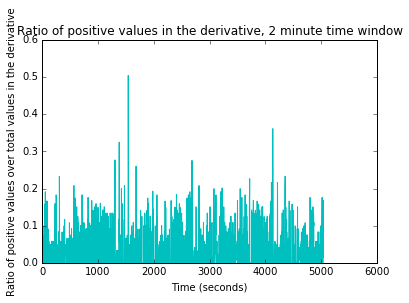

In [25]:
plot_output(output)

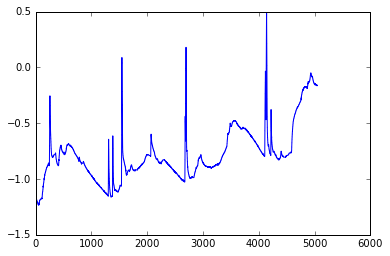

In [28]:
# original data
plt.plot(time,data)

In [26]:
window_length = 4.0
output_4 = derivative_analysis(time, data, window_length)

window length:  4.0  minutes
len(time): 301247
max(time): 5044.99571667
limit:  1261


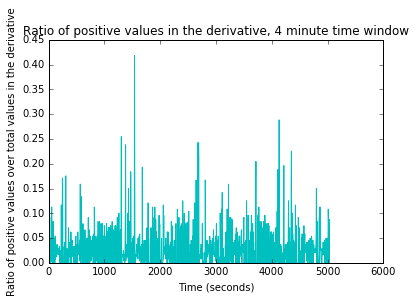

In [27]:
plt.plot(output_4[:,0], output_4[:,4], color='c', label='output')
plt.title("Ratio of positive values in the derivative, 4 minute time window")
plt.xlabel("Time (seconds)")
plt.ylabel("Ratio of positive values over total values in the derivative")
plt.show()

In [39]:
threshold = 0.17
y = output_4[:,4]
y = y>threshold

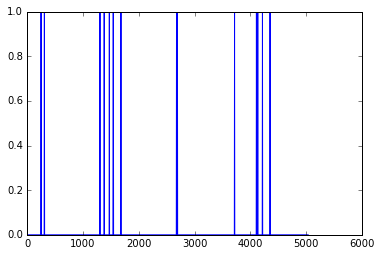

In [40]:
plt.plot(output_4[:,0], y)

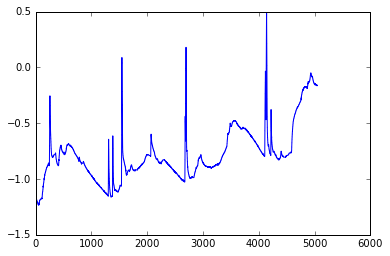

In [41]:
# original data
plt.plot(time,data)

### export to csv to be used for analysis

In [67]:
blop = np.zeros(5*len(y))

In [68]:
for i in xrange(len(blop)):
    j = i // 5
    blop[i] = y[j]

In [69]:
sum(blop)

95.0

In [70]:
sum(y)

19

In [78]:
blop = np.append(blop, [False,False,False])

In [79]:
import pandas as pd
blop_df = pd.DataFrame(blop)

In [80]:
len(blop_df)

24108

In [74]:
start_date = '2016-03-02 10:59:00'

In [75]:
end_date = '2016-03-19 04:46:00'

In [76]:
rng = pd.date_range(start = start_date, end = end_date, freq='min')

In [77]:
len(rng)

24108

In [81]:
df = pd.Series(blop, index=rng, name='shower_detection')

In [82]:
df.head()

2016-03-02 10:59:00    0
2016-03-02 11:00:00    0
2016-03-02 11:01:00    0
2016-03-02 11:02:00    0
2016-03-02 11:03:00    0
Freq: T, Name: shower_detection, dtype: float64

In [83]:
df.to_csv("shower_detection_1st.csv")